# ImpDAR Migration Tutorial

This notebook functions as a sort of tutorial for the migration routines currently implemented in our geophysical processing toolkit for impulse radar (<a href="https://github.com/dlilien/ImpDAR">ImpDAR</a>). First, I review a bit of the background on what migration is and why we need to use it to properly interpret geophysical datasets. I then describe the main groups of migration routines by stepping through a synthetic example, migrating the dataset with each method. I discuss the strengths and weaknesses for each as they come up as well as why one method may be chosen over another in a given case. Finally, I implement an actual data example from Hercules Dome.

Much of this material, including the theory but also the algorithms themselves, is taken straight from the textbooks (i.e. Yilmaz, 2001; Sheriff and Geldart, 1995) as well as some of the primary literature (cited in line below).

## What is Migration?

The goal of migration is to transform a geophysical dataset into an image that accurately represents the subsurface stratigraphy. Migration is a mathematical transformation in which geophysical events (timing of wave return) are re-located to where the event (the reflection) occurred in the subsurface rather than the location that it was recorded at the surface. Because off-nadir information intrudes into each trace, the image must be migrated as a whole to describe the true reflector geometry. Migration adjusts the angle of dipping reflectors, shortens and moves reflectors updip, unravels bowties, and most generally collapses diffractions.

![Raypaths](Raypaths_for_a_Dipping_Reflector.png)

The migration problem is illustrated in the image above. Dipping reflectors are imaged by an off-nadir ('apparent') reflection. The ray path of the apparent reflection is not the same as the depth of the reflector directly below the source. The _migrator's equation_ is a simple analytic way to adjust the angle of a dipping reflector,
$$tan(\xi_a) = sin(\xi)$$
where $\xi$ is the true reflector dip and $\xi_a$ is the apparent dip shown in the unmigrated image. While this equation is useful, it does not provide the full capability of migrating a full geophysical image. To do that, I explore a few different methods below. 

_As a note: migration typically assumes coincident source and receiver, meaning that this processing step should be carried out after any stacking or move-out corrections._

Migration methods outlined below:

- Diffraction Stack Migration (i.e. Kirchhoff)

- Frequency-Wavenumber Migration (e.g. Stolt, Gazdag, etc.)

- Finite-Difference Migration

- SeisUnix Migration Routines (ImpDAR converts to .segy, does the migration in SU, then converts back)

## Synthetic Example

Here, I create a synthetic domain to use as an example for the ImpDAR migration routines. For this case, the permittivity is elevated ($\epsilon_r =$ 12 inside and 3.2 outside) within the dark blue box in the image below.
<img src="./Box_Permittivity.png" width="500">
Loading this domain into gprmax (a finite-difference time-domain modeling software), I simulate a common offset radar survey over the box with the output as a synthetic radargram. The source is a 3-MHz wave from a Hertzian Dipole antenna. Source-receiver antenna separation is 40 m, and the step size between traces is 4 m.

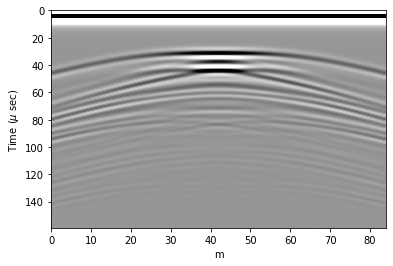

In [1]:
# We get annoying warnings about backends that are safe to ignore
import warnings
warnings.filterwarnings('ignore')

# Load the synthetic data
from impdar.lib import load
import numpy as np
dat = load.load('mat','data/synthetic_radargram.mat')[0]

# Plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(dat.data,cmap='Greys',aspect='auto',vmin=-1,vmax=1,
           extent=[min(dat.dist),max(dat.dist),max(dat.travel_time)*169/2,min(dat.travel_time)*169/2.]);
plt.xlabel('m');
plt.ylabel('Time ($\mu$ sec)');

This synthetic image illustrates why we need to migrate. There are large hyperbola that extend away from the actual location of the box in both horizontal directions. These hyperbola, or diffraction curves, do not accurately represent the subsurface stratigraphy, they are only a result of imaging the box from the side as an off-nadir reflector.

_As a note: The domian is slightly different because gprMax needs some room around the edges for a 'perfectly matched layer' boundary condition._

## 1) Diffraction-Stack Migration -- 'Kirchhoff'

The first migration method that I use here is the most direct to explain conceptually. Originally (~1920's), geophysical datesets were migrated by hand, and this method follows the logic used then. The energy along each diffraction curve is summed and placed at the apex of the curve (Hagedoorn, 1954). The diffraction curves are expected to be hyperbolic (in a constant velocity medium they will be), so here we iterate through each point of the image, looking for a hyperbolic diffraction curve and integrating the power along it.

Kirchhoff Migration (diffraction summation) of 85x1598 matrix
Kirchhoff Migration of 85x1598 matrix complete in 0.14 seconds


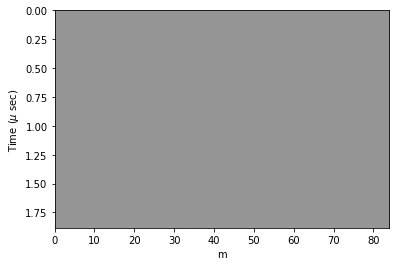

In [2]:
# Reload the unmigrated data
dat = load.load('mat','data/synthetic_radargram.mat')[0]

# Migrate
dat.migrate(mtype='kirch');

# Plot
plt.imshow(dat.data,cmap='Greys',aspect='auto',vmin=-.25,vmax=.25,
           extent=[min(dat.dist),max(dat.dist),max(dat.travel_time),min(dat.travel_time)]);
plt.xlabel('m');
plt.ylabel('Time ($\mu$ sec)');

Now we can see the box in its original location (i.e. ~200-300 lateral distance and ~0.5-1.0 $\mu$s). This method seems to work, but it is slow (even for this small synthetic dataset) and it 'over migrates' through much of the domain as can be seen by the upward facing hyperbola around the edges and below the box.

Summary of Kirchhoff Migration:
- Strengths
    - Conceptually simple.
    - Migrates steeply dipping reflectors.
- Weaknesses
    - Slow.
    - Over migrates.
    - No lateral velocity variation.

## 2) Frequency-Wavenumber Migration

Migration is commonly done in the frequency domain. In this case, the transformation is one from vertical frequency ($\omega_z$) to vertical wavenumber ($k_z$). This transformation is done in the frequency domain, so a 2-D Fourier transform is used in these methods. There are many such migration routines; here I highlight a couple popular ones.

### 2a) Stolt Migration (Stolt, 1978)

This is the first and probably the simplest of the frequency-wavenumber migration routines. It is done over the entire domain simultaneously, so it requires the assumption of a constant velocity throughout. The transformation done here is 

$$ P(x,z,t=0)= \int \int \left [ \frac{v}{2} \frac{k_z}{\sqrt{k_x^2+k_z^2}} \right ] P \left ( k_x,0,v/2 \sqrt{k_x^2+k_z^2} \right ) e^{-ik_x x-ik_z z}  dk_x dk_z $$

where an interpolation is done from $\omega_z$ to $k_z$ in frequency-space.

Stolt Migration (f-k migration) of 85x1598 matrix
Interpolating from temporal frequency (ws) to vertical wavenumber (kz):
Interpolating:
0 MHz, 53 MHz, 106 MHz, 159 MHz, 212 MHz, 265 MHz, 318 MHz, 371 MHz, Rescaling TWTT

Stolt Migration of 85x799 matrix complete in 3.12 seconds


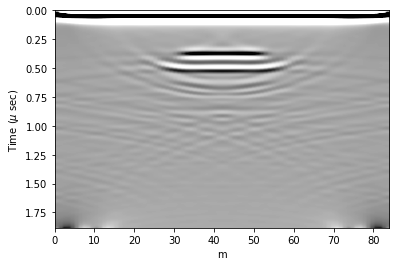

In [3]:
# Reload the unmigrated data
dat = load.load('mat','data/synthetic_radargram.mat')[0]
twtt = dat.travel_time

# Migrate
dat.migrate(mtype='stolt',htaper=10,vtaper=20);

# Plot
plt.imshow(dat.data,cmap='Greys',aspect='auto',vmin=-1,vmax=1,
           extent=[min(dat.dist),max(dat.dist),max(twtt),min(twtt)]);
plt.xlabel('m');
plt.ylabel('Time ($\mu$ sec)');

Stolt migration is great in places where the velocity is known to be constant. It is quite a bit faster than the other routines. Here though, we need to be careful about migrating power in from the edges of the domain, as can be seen in the lower corners above. For this reason, we apply a linear taper to the data so that the Fast Fourier Transform being used does not instantaneously switch from data to zeros around the edges.

Summary of Stolt Migration:

- Strengths
    - Fast.
    - Resolves steeply dipping layers
- Weaknesses
    - Constant velocity.

### 2b) Phase-Shift Migration (Gazdag, 1978)

This second frequency wavenumber migration routines is actually a set of a few. A phase-shifting operator $e^{-ik_z z} is applied at each z-step in downward continuation. These methods are advantageous in that they allow variable velocity as one steps down. Generally, this only allows vertical velocity variation (which I explore here) but there is also a case which accomadates lateral velocity variation (phase-shift plus interpolation) which I will not describe here.

In [4]:
# Reload the unmigrated data
dat = load.load('mat','data/synthetic_radargram.mat')[0]

from impdar.lib.migrationlib.mig_python import getVelocityProfile
import numpy as np

# create an artificial velocity-depth profile
mean_v = 169e6
z = dat.travel_time*1e-6*mean_v
v = 10e6*np.sin(2.*np.pi*z/100.) + mean_v
vels_in = np.transpose([v,z])

# save velocity profile for migration below
np.savetxt('Phsh_vel_profile.txt',vels_in)

# Use the ImpDAR command to get the interpolated velocity profile 
# dependent on travel time instead of depth
vmig = getVelocityProfile(dat,vels_in)

Interpolating the velocity profile.
Velocity profile finished in 0.00 seconds.


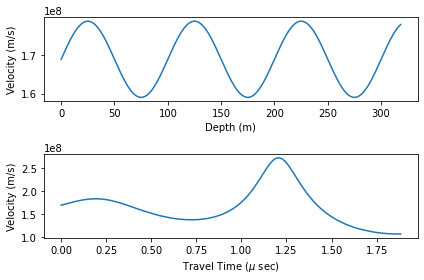

In [5]:
# Plot
ax1 = plt.subplot(211);
plt.plot(z,v);
plt.ylabel('Velocity (m/s)');
plt.xlabel('Depth (m)');
ax1 = plt.subplot(212);
plt.plot(dat.travel_time,vmig);
plt.ylabel('Velocity (m/s)');
plt.xlabel('Travel Time ($\mu$ sec)');
plt.tight_layout();

Phase-Shift Migration of 85x1598 matrix
Velocities loaded from Phsh_vel_profile.txt.
Interpolating the velocity profile.
Velocity profile finished in 0.00 seconds.
1-D velocity structure, Gazdag Migration
Velocities (m/s): %.2e [1.69000000e+08 1.69125225e+08 1.69250429e+08 ... 1.78019586e+08
 1.78072954e+08 1.78124899e+08]
Depths (m): [0.00000000e+00 1.99306291e-01 3.98612583e-01 ... 3.17893535e+02
 3.18092841e+02 3.18292147e+02]
Travel Times ($\mu$ sec): [0.00000000e+00 1.17932717e-03 2.35865434e-03 ... 1.88102683e+00
 1.88220616e+00 1.88338549e+00]
Time 0.00e+00, Time 1.18e-07, Time 2.36e-07, Time 3.54e-07, Time 4.72e-07, Time 5.90e-07, Time 7.08e-07, Time 8.26e-07, Time 9.43e-07, Time 1.06e-06, Time 1.18e-06, Time 1.30e-06, Time 1.42e-06, Time 1.53e-06, Time 1.65e-06, Time 1.77e-06, 
Phase-Shift Migration of 85x1598 matrix complete in 90.70 seconds


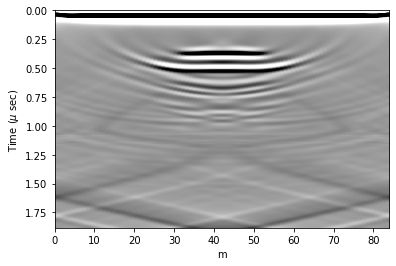

In [6]:
# Migrate
dat.migrate(mtype='phsh',htaper=20,vtaper=5,vel_fn='Phsh_vel_profile.txt');

# Plot
plt.imshow(dat.data,cmap='Greys',aspect='auto',vmin=-1,vmax=1,
           extent=[min(dat.dist),max(dat.dist),max(dat.travel_time),min(dat.travel_time)]);
plt.xlabel('m');
plt.ylabel('Time ($\mu$ sec)');

Much like the result from Kirchhoff migration, we see upward dipping 'smileys' in this migrated image. 

Summary of Phase-Shift Migration:

- Strengths
    - Accomodates velocity variation (particularly appropriate for vertical variations, i.e. in snow or similar).
- Weaknesses
    - Maximum dip angle.

## 3) Finite-Difference Migration

This is a full waveform modeling that essentially runs the arrow of time backward in order to map the geophysical event into an actual reflection location. The beginnings of this method are implemented in ImpDAR, but we have not fully executed this script yet. Because of computational expense, this should probably be written in a high-performance language instead of python. We could do this ourselves, but SeisUnix has already done it (likely better than we would). 

## 4) SeisUnix Migration Routines

There are many migration routines implemented in SeisUnix. I have no desire to replicate the work that they have done, but I wrote something into ImpDAR that allows the user to easily convert their data to .segy, migrate with SeisUnix, then convert back, all in a kind of black box fashion with only one command. 


### References

Yilmaz (2001). Seismic Data Processing.

Sherrif and Geldart (1995). Exploration Seismology.

Hagedorn (1954). Seismic Imaging Migration.

Stolt (1978). Migration by Fourier Transform.

Gazdag (1978). Wave Equation Migration with the Phase-Shift Method.